In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import Constant
from tensorflow.keras import optimizers, losses
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import math

%matplotlib inline

# 1. Data Set

In this project, I will focus on Apple.Inc stock price prediction by it's own historical stock information.

# 2. Data Preproccessing

In [128]:
data = pd.read_csv("AAPL.csv").iloc[:,4]
data

0        79.018570
1        77.282860
2        77.704285
3        77.148575
4        77.637146
5        76.645714
6        76.134285
7        76.532860
8        78.055717
9        79.622856
10       79.178574
11       77.238571
12       78.438568
13       78.787140
14       79.454285
15       78.010002
16       78.642860
17       72.357140
18       71.535713
19       71.397141
20       71.514282
21       71.647141
22       72.684288
23       73.227142
24       73.215714
25       74.239998
26       75.570000
27       76.565712
28       76.559998
29       77.775711
           ...    
977     171.100006
978     170.149994
979     169.979996
980     173.139999
981     174.960007
982     174.970001
983     174.089996
984     173.070007
985     169.479996
986     171.850006
987     171.050003
988     169.800003
989     169.639999
990     169.009995
991     169.320007
992     169.369995
993     172.669998
994     171.699997
995     172.270004
996     172.220001
997     173.970001
998     176.

In [129]:
MA5 = np.empty([987])
MA10 = np.empty([987])
MA20 = np.empty([987])
for i in range(987):
    MA5[i] = sum(data[i+15:i+20])/5
    MA10[i] = sum(data[i+10:i+20])/10
    MA20[i] = sum(data[i:i+20])/20

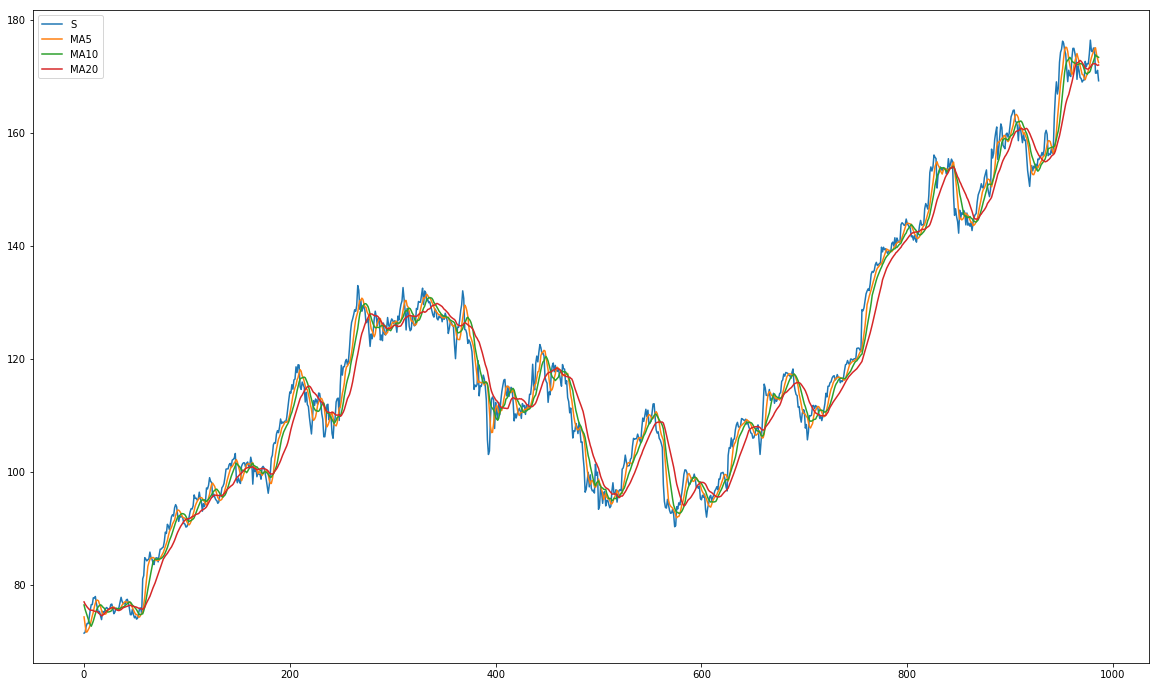

In [130]:
fig, ax = plt.subplots(figsize=(20,12))
data1 = np.array(data[20:])
plt.plot(data1,label ="S")
plt.plot(MA5,label ="MA5")
plt.plot(MA10,label ="MA10")
plt.plot(MA20,label ="MA20")
plt.legend()

# 3. Construct Training set and Test set for MLP predictor

In [131]:
v_sub1 = np.vstack((MA5,MA10,MA20)).T

In [132]:
v_sub2 = np.empty(shape = [987,15])
for i in range(987):
    for j in range(15):
        v_sub2[i,j] = data.iloc[i+j+5]

In [133]:
v = np.concatenate((v_sub1,v_sub2),axis = 1)
v.shape

(987, 18)

In [134]:
data_input = np.vstack((v.T,data1,range(987))).T
train, test = train_test_split(data_input,test_size=0.1,random_state=123)
train=train[np.argsort(train[:,19])]
test=test[np.argsort(test[:,19])]
x_train = train[:,:18]
y_train = train[:,18]
x_test = test[:,:18]
y_test = test[:,18]

In [135]:
from sklearn import preprocessing
x_train = preprocessing.scale(x_train)
x_test = preprocessing.scale(x_test)

# 4. MLP predictor

## 4a. find the hidden layer dim size k by PCA

In [136]:
G = np.corrcoef(x_train.T)
G.shape

(18, 18)

In [137]:
from numpy import linalg as la
eigenv=la.eig(G)
eigenValues=eigenv[0]
eigenValues=np.sort(eigenValues)[::-1]

In [138]:
RAT=[]
eigen_sum=0
for i in range(18):
    eigen_sum=eigen_sum+eigenValues[i]
    ratio=eigen_sum/sum(eigenValues)
    RAT.append(ratio)
# Identify the smallest j such that RATj ≥ 99.5% 
j=0
for i in range(18):
    if RAT[i]>=0.995:
        j=i
        break
j+1

2

By the result above, I set the dim of hidden layer be 2

# 4b. Construct the MLP predictor

In [139]:
h = 2
mlp = Sequential()
mlp.add(Dense(h, activation='relu', input_dim=18, bias_initializer=Constant(value=5)))
mlp.add(Dense(1, activation='relu', bias_initializer=Constant(value=40)))
mlp.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 2)                 38        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 3         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


numbers of info = 888

numbers of weight and threshold = 41

Ratio = 888/41 = 21.66, which is a big ratio so we can ignore overfitting problem.

# 5. Training the MLP predictor

In [140]:
mlp.compile(optimizer=optimizers.SGD(learning_rate=0.001, decay=1e-7), loss='mean_squared_error')

In [141]:
class mlpMyHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
      self.MSEtrain = []
      self.MSEtest = []
#    def on_batch_end(self, batch, logs={}):
#      self.MSEtrain.append(self.model.evaluate(x_train,y_train,verbose = 0))
#      self.MSEtest.append(self.model.evaluate(x_test,y_test,verbose = 0))

mlpMyMonitor1 = mlpMyHistory()

es1 = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200, restore_best_weights=True)

In [142]:
# For saving the best model choosen by keras.
filepath = 'BestModel1.h5'
checkpointer = callbacks.ModelCheckpoint(filepath=filepath, 
                                         monitor='val_loss', save_best_only=True, mode='auto', save_freq='epoch')

In [143]:
mlpMonitor = mlp.fit(x_train, y_train, epochs=8000, batch_size=12, 
                     callbacks = [mlpMyMonitor1, es1,checkpointer], validation_data = (x_test, y_test), verbose = 1)

Train on 888 samples, validate on 99 samples
Epoch 1/8000
888/888 [==============================] - 0s 365us/sample - loss: 443.3685 - val_loss: 15.6303
Epoch 2/8000
888/888 [==============================] - 0s 105us/sample - loss: 14.0213 - val_loss: 15.6434
Epoch 3/8000
888/888 [==============================] - 0s 108us/sample - loss: 15.0753 - val_loss: 11.9872
Epoch 4/8000
888/888 [==============================] - 0s 116us/sample - loss: 9.4479 - val_loss: 20.2898
Epoch 5/8000
888/888 [==============================] - 0s 101us/sample - loss: 9.4606 - val_loss: 18.6657
Epoch 6/8000
888/888 [==============================] - 0s 109us/sample - loss: 8.9754 - val_loss: 11.4939
Epoch 7/8000
888/888 [==============================] - 0s 129us/sample - loss: 6.1293 - val_loss: 14.8674
Epoch 8/8000
888/888 [==============================] - 0s 105us/sample - loss: 14.5668 - val_loss: 12.4571
Epoch 9/8000
888/888 [==============================] - 0s 99us/sample - loss: 6.6187 - val_lo

Epoch 77/8000
888/888 [==============================] - 0s 96us/sample - loss: 3.3023 - val_loss: 9.8081
Epoch 78/8000
888/888 [==============================] - 0s 92us/sample - loss: 6.1769 - val_loss: 14.3108
Epoch 79/8000
888/888 [==============================] - 0s 90us/sample - loss: 3.1458 - val_loss: 20.2141
Epoch 80/8000
888/888 [==============================] - 0s 89us/sample - loss: 4.2978 - val_loss: 10.1373
Epoch 81/8000
888/888 [==============================] - 0s 89us/sample - loss: 3.3110 - val_loss: 10.1855
Epoch 82/8000
888/888 [==============================] - 0s 88us/sample - loss: 3.4009 - val_loss: 13.3154
Epoch 83/8000
888/888 [==============================] - 0s 99us/sample - loss: 3.9271 - val_loss: 7.3251
Epoch 84/8000
888/888 [==============================] - 0s 141us/sample - loss: 3.3983 - val_loss: 11.0328
Epoch 85/8000
888/888 [==============================] - 0s 90us/sample - loss: 3.8614 - val_loss: 11.9572
Epoch 86/8000
888/888 [===============

888/888 [==============================] - 0s 116us/sample - loss: 3.5277 - val_loss: 13.3613
Epoch 154/8000
888/888 [==============================] - 0s 129us/sample - loss: 3.5864 - val_loss: 11.9360
Epoch 155/8000
888/888 [==============================] - 0s 138us/sample - loss: 3.3309 - val_loss: 14.3036
Epoch 156/8000
888/888 [==============================] - 0s 177us/sample - loss: 3.0792 - val_loss: 13.8783
Epoch 157/8000
888/888 [==============================] - 0s 144us/sample - loss: 3.1689 - val_loss: 12.1935
Epoch 158/8000
888/888 [==============================] - 0s 92us/sample - loss: 2.9163 - val_loss: 12.3725
Epoch 159/8000
888/888 [==============================] - 0s 132us/sample - loss: 2.8139 - val_loss: 9.9555
Epoch 160/8000
888/888 [==============================] - 0s 150us/sample - loss: 3.7972 - val_loss: 12.1445
Epoch 161/8000
888/888 [==============================] - 0s 152us/sample - loss: 3.3511 - val_loss: 13.2428
Epoch 162/8000
888/888 [============

888/888 [==============================] - 0s 163us/sample - loss: 3.2768 - val_loss: 15.1611
Epoch 229/8000
888/888 [==============================] - 0s 100us/sample - loss: 3.2644 - val_loss: 11.0047
Epoch 230/8000
888/888 [==============================] - 0s 108us/sample - loss: 3.1773 - val_loss: 11.5897
Epoch 231/8000
888/888 [==============================] - 0s 169us/sample - loss: 3.2760 - val_loss: 11.9837
Epoch 232/8000
888/888 [==============================] - 0s 135us/sample - loss: 3.0261 - val_loss: 9.0693
Epoch 233/8000
888/888 [==============================] - 0s 106us/sample - loss: 3.1984 - val_loss: 8.5716
Epoch 234/8000
888/888 [==============================] - 0s 125us/sample - loss: 3.2901 - val_loss: 15.0787
Epoch 235/8000
888/888 [==============================] - 0s 101us/sample - loss: 3.1811 - val_loss: 12.6823
Epoch 236/8000
888/888 [==============================] - 0s 125us/sample - loss: 3.0795 - val_loss: 10.4716
Epoch 237/8000
888/888 [============

888/888 [==============================] - 0s 100us/sample - loss: 3.1489 - val_loss: 13.1259
Epoch 304/8000
888/888 [==============================] - 0s 88us/sample - loss: 3.2785 - val_loss: 11.9170
Epoch 305/8000
888/888 [==============================] - 0s 94us/sample - loss: 3.0239 - val_loss: 11.1748
Epoch 306/8000
888/888 [==============================] - 0s 109us/sample - loss: 3.1136 - val_loss: 10.0509
Epoch 307/8000
888/888 [==============================] - 0s 89us/sample - loss: 2.8907 - val_loss: 12.6152
Epoch 308/8000
888/888 [==============================] - 0s 94us/sample - loss: 3.0511 - val_loss: 14.7093
Epoch 309/8000
888/888 [==============================] - 0s 92us/sample - loss: 3.3490 - val_loss: 11.3002
Epoch 310/8000
888/888 [==============================] - 0s 94us/sample - loss: 3.0531 - val_loss: 11.0855
Epoch 311/8000
888/888 [==============================] - 0s 90us/sample - loss: 3.4933 - val_loss: 12.4165
Epoch 312/8000
888/888 [=================

Epoch 379/8000
888/888 [==============================] - 0s 104us/sample - loss: 2.9238 - val_loss: 13.3368
Epoch 380/8000
888/888 [==============================] - 0s 134us/sample - loss: 3.1781 - val_loss: 17.9068
Epoch 381/8000
888/888 [==============================] - 0s 139us/sample - loss: 3.4586 - val_loss: 12.4080
Epoch 382/8000
888/888 [==============================] - 0s 101us/sample - loss: 2.9607 - val_loss: 9.2373
Epoch 383/8000
888/888 [==============================] - 0s 90us/sample - loss: 3.0063 - val_loss: 10.2964
Epoch 384/8000
888/888 [==============================] - 0s 100us/sample - loss: 2.8768 - val_loss: 12.0003
Epoch 385/8000
888/888 [==============================] - 0s 91us/sample - loss: 3.3730 - val_loss: 13.4798
Epoch 386/8000
888/888 [==============================] - 0s 90us/sample - loss: 2.9918 - val_loss: 13.5073
Epoch 387/8000
888/888 [==============================] - 0s 92us/sample - loss: 2.8476 - val_loss: 12.2658
Epoch 388/8000
888/888 [

Epoch 455/8000
888/888 [==============================] - 0s 91us/sample - loss: 3.1576 - val_loss: 11.0410
Epoch 456/8000
888/888 [==============================] - 0s 92us/sample - loss: 2.9042 - val_loss: 14.5502
Epoch 457/8000
888/888 [==============================] - 0s 97us/sample - loss: 2.9240 - val_loss: 11.2318
Epoch 458/8000
888/888 [==============================] - 0s 92us/sample - loss: 3.0506 - val_loss: 10.9751
Epoch 459/8000
888/888 [==============================] - 0s 96us/sample - loss: 3.2485 - val_loss: 9.1377
Epoch 460/8000
888/888 [==============================] - 0s 90us/sample - loss: 3.1644 - val_loss: 9.2948
Epoch 461/8000
888/888 [==============================] - 0s 111us/sample - loss: 2.9180 - val_loss: 9.4641
Epoch 462/8000
888/888 [==============================] - 0s 88us/sample - loss: 2.8408 - val_loss: 12.8174
Epoch 463/8000
888/888 [==============================] - 0s 90us/sample - loss: 3.1949 - val_loss: 11.1059
Epoch 464/8000
888/888 [======

Epoch 531/8000
888/888 [==============================] - 0s 90us/sample - loss: 2.9172 - val_loss: 17.3340
Epoch 532/8000
888/888 [==============================] - 0s 92us/sample - loss: 3.3050 - val_loss: 18.1209
Epoch 533/8000
888/888 [==============================] - 0s 89us/sample - loss: 3.0210 - val_loss: 10.1420
Epoch 534/8000
888/888 [==============================] - 0s 90us/sample - loss: 3.4295 - val_loss: 10.0592
Epoch 535/8000
888/888 [==============================] - 0s 91us/sample - loss: 3.0544 - val_loss: 10.3141
Epoch 536/8000
888/888 [==============================] - 0s 93us/sample - loss: 2.8397 - val_loss: 11.9613
Epoch 537/8000
888/888 [==============================] - 0s 91us/sample - loss: 2.9033 - val_loss: 11.2335
Epoch 538/8000
888/888 [==============================] - 0s 93us/sample - loss: 2.9005 - val_loss: 14.8538
Epoch 539/8000
888/888 [==============================] - 0s 109us/sample - loss: 2.9152 - val_loss: 12.8051
Epoch 540/8000
888/888 [===

Epoch 607/8000
888/888 [==============================] - 0s 93us/sample - loss: 3.3190 - val_loss: 8.2211
Epoch 608/8000
888/888 [==============================] - 0s 87us/sample - loss: 2.8479 - val_loss: 11.0267
Epoch 609/8000
888/888 [==============================] - 0s 92us/sample - loss: 3.2310 - val_loss: 9.8741
Epoch 610/8000
888/888 [==============================] - 0s 91us/sample - loss: 2.9570 - val_loss: 12.1509
Epoch 611/8000
888/888 [==============================] - 0s 91us/sample - loss: 3.1435 - val_loss: 11.3675
Epoch 612/8000
888/888 [==============================] - 0s 103us/sample - loss: 3.0120 - val_loss: 10.2899
Epoch 613/8000
888/888 [==============================] - 0s 88us/sample - loss: 2.8240 - val_loss: 13.9187
Epoch 614/8000
888/888 [==============================] - 0s 92us/sample - loss: 3.3460 - val_loss: 11.3224
Epoch 615/8000
888/888 [==============================] - 0s 93us/sample - loss: 2.7951 - val_loss: 10.9590
Epoch 616/8000
888/888 [=====

Epoch 683/8000
888/888 [==============================] - 0s 92us/sample - loss: 2.9384 - val_loss: 12.4097
Epoch 684/8000
888/888 [==============================] - 0s 90us/sample - loss: 2.9073 - val_loss: 8.0847
Epoch 685/8000
888/888 [==============================] - 0s 91us/sample - loss: 2.8631 - val_loss: 12.0334
Epoch 686/8000
888/888 [==============================] - 0s 95us/sample - loss: 2.8475 - val_loss: 12.6488
Epoch 687/8000
888/888 [==============================] - 0s 89us/sample - loss: 2.8323 - val_loss: 12.3762
Epoch 688/8000
888/888 [==============================] - 0s 93us/sample - loss: 2.8649 - val_loss: 8.4539
Epoch 689/8000
888/888 [==============================] - 0s 89us/sample - loss: 3.0254 - val_loss: 15.3442
Epoch 690/8000
888/888 [==============================] - 0s 91us/sample - loss: 3.1924 - val_loss: 11.6459
Epoch 691/8000
888/888 [==============================] - 0s 113us/sample - loss: 2.9896 - val_loss: 9.8336
Epoch 692/8000
888/888 [======

888/888 [==============================] - 0s 96us/sample - loss: 2.8730 - val_loss: 11.9182
Epoch 759/8000
888/888 [==============================] - 0s 91us/sample - loss: 3.0561 - val_loss: 10.5216
Epoch 760/8000
888/888 [==============================] - 0s 91us/sample - loss: 2.9576 - val_loss: 9.1621
Epoch 761/8000
888/888 [==============================] - 0s 91us/sample - loss: 3.0123 - val_loss: 10.9399
Epoch 762/8000
888/888 [==============================] - 0s 85us/sample - loss: 2.8939 - val_loss: 16.7855
Epoch 763/8000
888/888 [==============================] - 0s 88us/sample - loss: 3.2953 - val_loss: 12.1014
Epoch 764/8000
888/888 [==============================] - 0s 93us/sample - loss: 2.9761 - val_loss: 9.5741
Epoch 765/8000
888/888 [==============================] - 0s 93us/sample - loss: 2.9290 - val_loss: 10.1464
Epoch 766/8000
888/888 [==============================] - 0s 93us/sample - loss: 2.8588 - val_loss: 11.5014
Epoch 767/8000
888/888 [=====================

Best MSE in Trainning set and Test set

In [144]:
bestmodel2 = load_model('BestModel1.h5')
x_train_MSE = math.sqrt(bestmodel2.evaluate(x_train,y_train))
x_test_MSE = math.sqrt(bestmodel2.evaluate(x_test,y_test))
print(x_train_MSE, x_test_MSE)

99/99 [==============================] - 0s 47us/sample - loss: 5.9377
2.1084561820912318 2.436736747399024


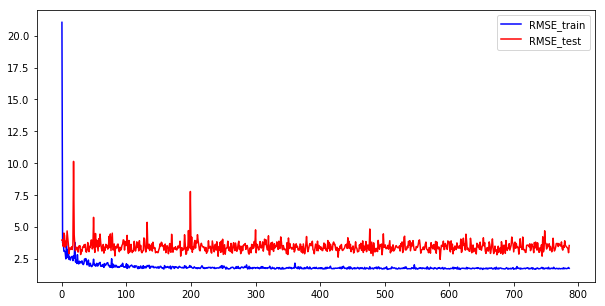

In [145]:
# plot loss and val_loss to choose the best epoch
loss_tr = np.sqrt(mlpMonitor.history["loss"])
loss_te = np.sqrt(mlpMonitor.history["val_loss"])

fig=plt.figure(figsize=(10,5))
plt.plot(loss_tr,c='b')
plt.plot(loss_te,c='r')
plt.legend(['RMSE_train','RMSE_test'],loc='best')

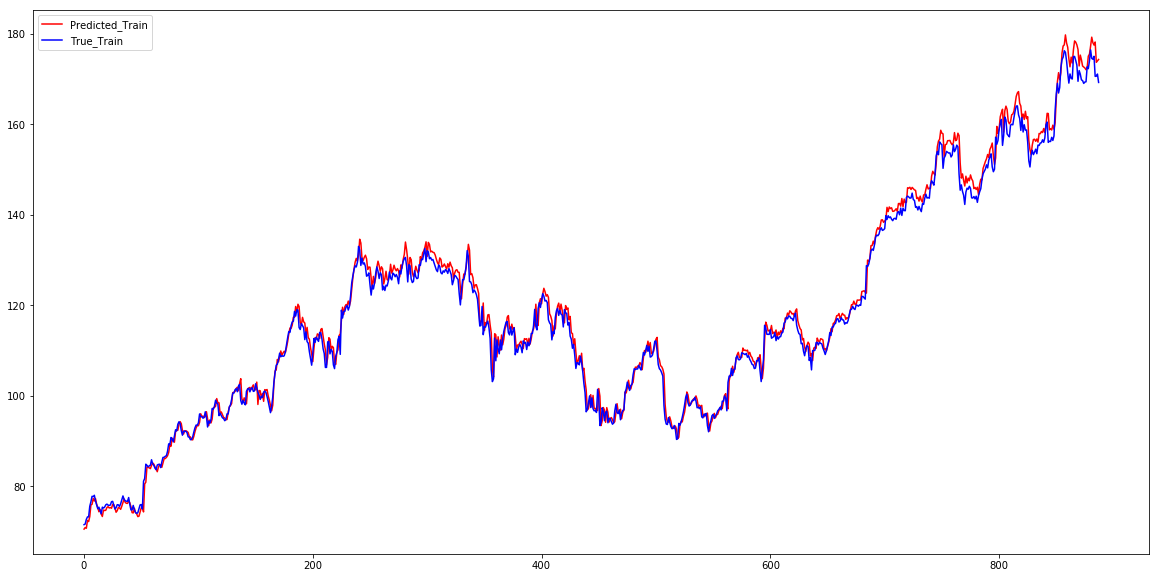

In [190]:
# plot the predicted Y and true Y on training set
y_pred_tr = mlp.predict(x_train)
fig=plt.figure(figsize=(20,10))
plt.plot(y_pred_tr,c='r')
plt.plot(y_train,c='b')
plt.legend(['Predicted_Train','True_Train'],loc='best')

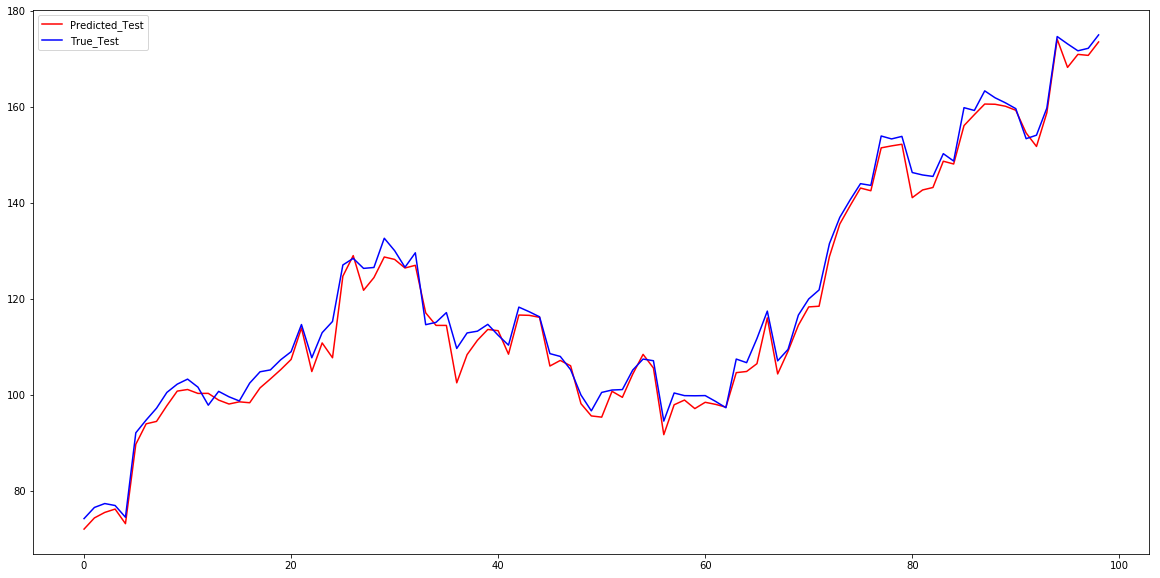

In [191]:
y_pred_te = mlp.predict(x_test)
fig=plt.figure(figsize=(20,10))
plt.plot(y_pred_te,c='r')
plt.plot(y_test,c='b')
plt.legend(['Predicted_Test','True_Test'],loc='best')

MREP for Train and Test

In [180]:
mrep_tr = np.mean(abs(y_pred_tr.T-y_train)/y_train)
mrep_te = np.mean(abs(y_pred_te.T-y_test)/y_test)
mrep_tr,mrep_te

(0.013174982337564414, 0.017259769618101047)

Comments: After tuning for a while, I found a best model which the MREP in both Trainning set and Test set are all around 1%

# 6. Compute NOD, W and IMP

In [192]:
nod = np.mean(mlp.layers[0](x_train).numpy(),axis=0)
nod

array([ 9.439279, 10.135482], dtype=float32)

In [193]:
for layer in mlp.layers:
    weights = layer.get_weights()
weights[0]

array([[3.6871982],
       [4.1332507]], dtype=float32)

In [194]:
weights[0][0]*nod[0],weights[0][1]*nod[1]

(array([34.80449], dtype=float32), array([41.892487], dtype=float32))

Impact IMP in two hidden nuerons are 34.80449 and 41.892487 respectively, we can see that the second neuron has the maximum impact on Zt

# 7. Compute INP, U and F

In [184]:
inp = np.average(x_train,axis = 0)
u = mlp.get_weights()[0]
inp

array([ 8.62473256e-15,  1.99990175e-15, -2.28395881e-15,  4.22584890e-15,
        7.02591138e-15,  2.64803194e-15,  5.52561000e-15,  3.32666827e-15,
        3.26965682e-15,  4.60492505e-15,  5.73365179e-15,  4.73545127e-15,
        4.92798995e-15,  6.75985794e-15,  2.67953827e-15,  3.15863452e-15,
        3.95229395e-15,  1.28525819e-15])

In [185]:
u

array([[ 0.15962464,  1.1044276 ],
       [-0.00774382,  0.37182555],
       [ 0.14113304, -0.45949015],
       [ 0.17951258, -0.38832632],
       [ 0.5183729 , -0.04185244],
       [-0.08022634,  0.20898981],
       [-0.41724938,  0.21664238],
       [-0.14366226,  0.17406487],
       [ 0.2378647 , -0.5070084 ],
       [ 0.26065123,  0.14440311],
       [ 0.16028266, -0.50629795],
       [ 0.16632263,  0.2838666 ],
       [ 0.06499295, -0.4799429 ],
       [-0.17375356,  0.04782402],
       [-0.5324563 ,  0.31813586],
       [-0.3118154 ,  0.1728371 ],
       [ 0.02278474, -0.469188  ],
       [ 2.741186  ,  3.1745622 ]], dtype=float32)

In [204]:
f1 = np.empty(18)
f2 = np.empty(18)
for i in range(18):
    f1[i] = inp[i]*u[i,0]
    f2[i] = inp[i]*u[i,1]

In [205]:
f1

array([ 1.37671980e-15, -1.54868709e-17, -3.22342050e-16,  7.58593019e-16,
        3.64204201e-15, -2.12441909e-16, -2.30555735e-15, -4.77916679e-16,
        7.77735948e-16,  1.20027938e-15,  9.19004941e-16,  7.87612727e-16,
        3.20284601e-16, -1.17454938e-15, -1.42673698e-15, -9.84910919e-16,
        9.00520037e-17,  3.52313162e-15])

In [206]:
f2

array([ 9.52539248e-15,  7.43614559e-16,  1.04945658e-15, -1.64100834e-15,
       -2.94051539e-16,  5.53411703e-16,  1.19708130e-15,  5.79056095e-16,
       -1.65774339e-15,  6.64965521e-16, -2.90293613e-15,  1.34423652e-15,
       -2.36515373e-15,  3.23283566e-16,  8.52457206e-16,  5.45929209e-16,
       -1.85436891e-15,  4.08013208e-15])

In [208]:
import heapq
number_of_elements = 5
heapq.nlargest(number_of_elements, abs(f1))

[3.6420420125402054e-15,
 3.523131622337139e-15,
 2.3055573549711443e-15,
 1.4267369777179423e-15,
 1.3767197969445706e-15]

We can see that the 5, 18, 7, 15 and 1 inputs have the largest impact on the first neuron.

In [210]:
heapq.nlargest(number_of_elements, abs(f2))

[9.525392475194246e-15,
 4.08013207535405e-15,
 2.902936125024562e-15,
 2.365153727804707e-15,
 1.854368911376774e-15]

We can see that the 1, 15, 11, 13 and 17 inputs have the largest impact on the second neuron.

In conclusion features MA5, S(t-1), S(t-3), S(t-7), S(t-9), S(t-11), S(t-13), S(t-14) impact most on the hidden layer. To be more specificly, the features MA5 and S(t-11) have more impact then others cause they both occurr in max 5 impact on first and second hidden nueron.